In [1]:
from PIL import Image
from numpy import *
from pylab import *
import scipy.misc
from scipy import ndimage
import numpy as np

In [2]:
import stereo
stereo = reload(stereo)

In [3]:
im_l = array(Image.open('scene1.row3.col3.ppm').convert('L'), 'f')
im_r = array(Image.open('scene1.row3.col4.ppm').convert('L'), 'f')

In [89]:
def plane_sweep_ncc_2dir(im_l, im_r, start, steps, wid):
    """ Find disparity image using SAD (sum of absolute difference). """

    m, n = im_l.shape

    # arrays to hold the different sums
    mean_l = np.zeros((m, n))
    mean_r = np.zeros((m, n))
    s1 = np.zeros((m, n))
    s1_l = np.zeros((m, n))
    s1_r = np.zeros((m, n))
    s2 = np.zeros((m, n))
    s2_l = np.zeros((m, n))
    s2_r = np.zeros((m, n))

    # array to hold depth planes
    dmaps_lr = np.zeros((m, n, steps))
    dmaps_rl = np.zeros((m, n, steps))

    # compute mean of patch
    ndimage.filters.uniform_filter(im_l, wid, mean_l)
    ndimage.filters.uniform_filter(im_r, wid, mean_r)

    # normalized images
    norm_l = im_l - mean_l
    norm_r = im_r - mean_r

    # try different disparities
    for displ in range(steps):
        # move left image to the right, compute sums
        # sum of nominator
        ndimage.filters.uniform_filter(np.roll(norm_l, -displ-start)*norm_r, wid, s1)
        ndimage.filters.uniform_filter(norm_l*np.roll(norm_r, +displ+start), wid, s2)
        # sum of denominator
        ndimage.filters.uniform_filter(
            np.roll(norm_l, -displ-start)*np.roll(norm_l, -displ-start), wid, s1_l)
        ndimage.filters.uniform_filter(
            np.roll(norm_r, +displ+start)*np.roll(norm_r, +displ+start), wid, s2_r)
        # sum of denominator
        ndimage.filters.uniform_filter(norm_r*norm_r, wid, s1_r)
        ndimage.filters.uniform_filter(norm_l*norm_l, wid, s2_l)

        # store ncc scores
        dmaps_lr[:, :, displ] = s1/np.sqrt(s1_l*s1_r)
        dmaps_rl[:, :, displ] = s2/np.sqrt(s2_l*s2_r)

    # pick best depth for each pixel
    dl = np.argmax(dmaps_lr, axis=2)
    dr = np.argmax(dmaps_rl, axis=2)
    dd = np.absolute(dl - dr)
    
    dl[dd>2] = 0  # if the difference is bigger than 2, ignore
    
    return dl

In [90]:
def plane_sweep_ncc_gauss_2dir(im_l, im_r, start, steps, wid):
    """ Find disparity image using SAD (sum of absolute difference). """

    m, n = im_l.shape

    # arrays to hold the different sums
    mean_l = np.zeros((m, n))
    mean_r = np.zeros((m, n))
    s1 = np.zeros((m, n))
    s1_l = np.zeros((m, n))
    s1_r = np.zeros((m, n))
    s2 = np.zeros((m, n))
    s2_l = np.zeros((m, n))
    s2_r = np.zeros((m, n))

    # array to hold depth planes
    dmaps_lr = np.zeros((m, n, steps))
    dmaps_rl = np.zeros((m, n, steps))

    # compute mean of patch
    ndimage.filters.gaussian_filter(im_l, wid, 0, mean_l)
    ndimage.filters.gaussian_filter(im_r, wid, 0, mean_r)

    # normalized images
    norm_l = im_l - mean_l
    norm_r = im_r - mean_r

    # try different disparities
    for displ in range(steps):
        # move left image to the right, compute sums
        # sum of nominator
        ndimage.filters.gaussian_filter(np.roll(norm_l, -displ-start)*norm_r, wid, 0, s1)
        ndimage.filters.gaussian_filter(norm_l*np.roll(norm_r, +displ+start), wid, 0, s2)
        # sum of denominator
        ndimage.filters.gaussian_filter(
            np.roll(norm_l, -displ-start)*np.roll(norm_l, -displ-start), wid, 0, s1_l)
        ndimage.filters.gaussian_filter(
            np.roll(norm_r, +displ+start)*np.roll(norm_r, +displ+start), wid, 0, s2_r)
        # sum of denominator
        ndimage.filters.gaussian_filter(norm_r*norm_r, wid, 0, s1_r)
        ndimage.filters.gaussian_filter(norm_l*norm_l, wid, 0, s2_l)

        # store ncc scores
        dmaps_lr[:, :, displ] = s1/np.sqrt(s1_l*s1_r)
        dmaps_rl[:, :, displ] = s2/np.sqrt(s2_l*s2_r)

    # pick best depth for each pixel
    dl = np.argmax(dmaps_lr, axis=2)
    dr = np.argmax(dmaps_rl, axis=2)
    dd = np.absolute(dl - dr)
    
    dl[dd>2] = 0  # if the difference is bigger than 2, ignore
    # you could put -1 here, as invalid value, and add post processing to fill this area
    
    return dl

In [80]:
start = 4
steps = 12
wid = 9
res = stereo.plane_sweep_ncc(im_l, im_r, start, steps, wid)

In [81]:
start = 1
steps = 12
wid = 3
res2 = stereo.plane_sweep_gauss(im_l, im_r, start, steps, wid)

In [91]:
start = 4
steps = 12
wid = 9
res3 = plane_sweep_ncc_2dir(im_l, im_r, start, steps, wid)

In [92]:
start = 1
steps = 12
wid = 3
res4 = plane_sweep_ncc_gauss_2dir(im_l, im_r, start, steps, wid)

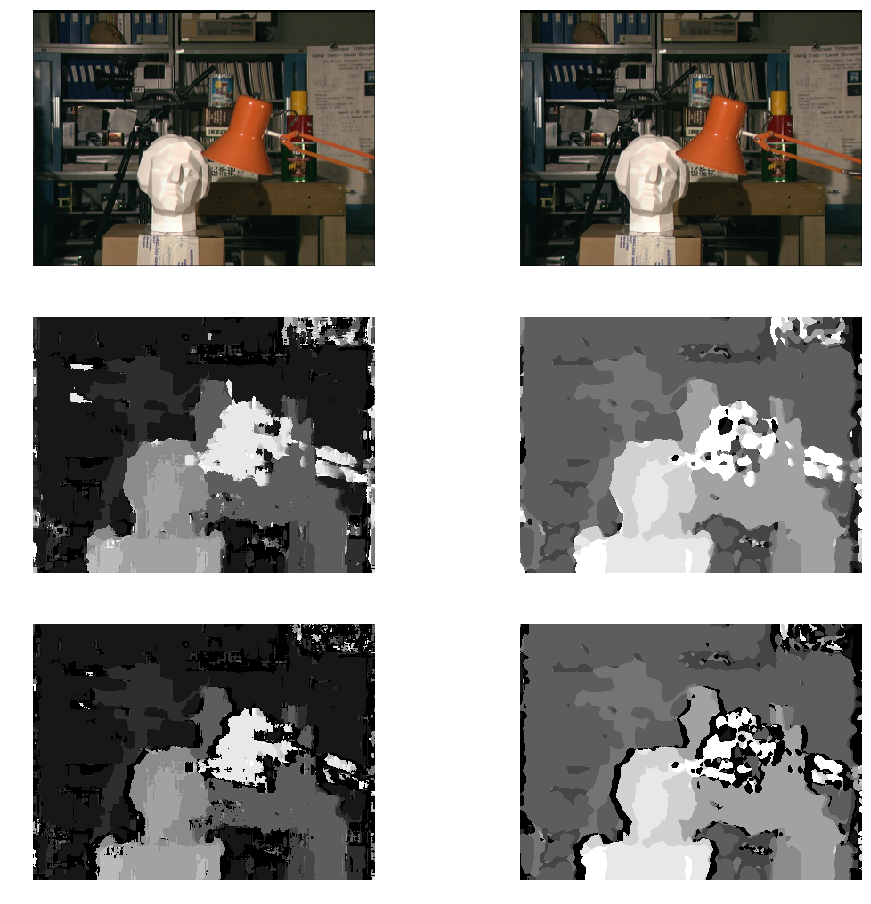

In [93]:
figure(figsize=(16, 16))
gray()
subplot(3, 2, 1)
imshow(Image.open('scene1.row3.col3.ppm'))
axis('off')
subplot(3, 2, 2)
imshow(Image.open('scene1.row3.col4.ppm'))
axis('off')
subplot(3, 2, 3)
imshow(res)
axis('off')
subplot(3, 2, 4)
imshow(res2)
axis('off')
subplot(3, 2, 5)
imshow(res3)
axis('off')
subplot(3, 2, 6)
imshow(res4)
axis('off')
show()